In [1]:
import pandas as pd
import numpy as np
import sklearn
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from acquire import get_zillow_data
from prepare import prep_zillow_data

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Pull in our data both scaled and unscaled

In [3]:
train, y_train, y_validate, y_test, X_train_scaled, X_train, X_validate, X_test, X_validate_scaled, X_test_scaled = prep_zillow_data('taxvaluedollarcnt')

# Explore
We will explore our prepped data to identify drivers of house value and relationships between variables.
***

We begin by creating a heatmap of that includes each of the features we retained from our prep phase:
- unit_sq_ft (formerly calculatedfinishedsquarefeet) 
- bedroom_count (formerly bedroomcnt)                    
- bathroom_count (formerly bathroomcnt)
- lot_size_sq_ft (formerly lotsizesquarefeet) 

Text(68.09375, 0.5, 'Features')

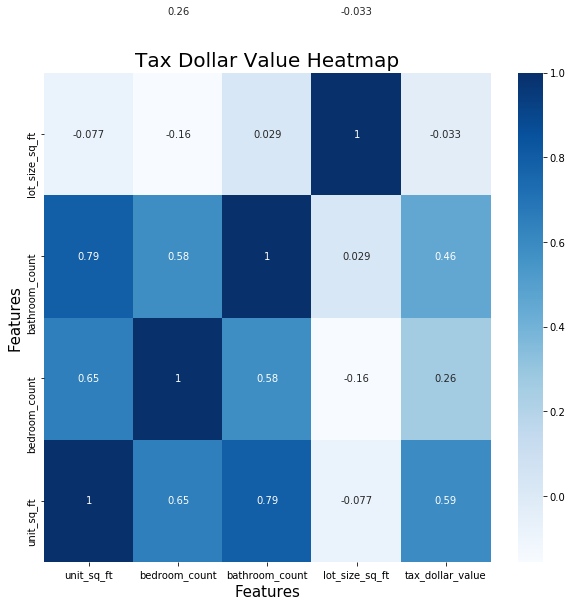

In [4]:
# creating copy of train DF to avoid altering the original
hmap_train = train.copy()

# creating scaler object
scaler = sklearn.preprocessing.MinMaxScaler()

# fitting scaler to train data
scaler.fit(hmap_train)

# scaling train data and converting to data frame
hmap_train = pd.DataFrame(scaler.transform(hmap_train))

# renaming columns as they were erased in the DF conversion
hmap_train.rename(columns={0: 'unit_sq_ft', 1: 'bedroom_count', 2: 'bathroom_count', 3: 'lot_size_sq_ft', 4: 'tax_dollar_value' }, inplace=True)

# plotting heatmap
plt.figure(figsize=(10,9))

sns.heatmap(hmap_train.corr(), cmap='Blues', annot=True)
plt.ylim(0, 4)
plt.title('Tax Dollar Value Heatmap', fontsize = 20)
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Features', fontsize = 15)

- Given their strong tones and coefficients, bathroom_count, bedroom_count and unit_sq_ft all appear to be strong drivers of house value.

- Given it's weak coloring an low coefficient, lot_size_sq_feet appears to be a weak drivr of house value.

- We will create hypothesis tests and visualizations to further explore each of these features in more depth.

## Feature: calculatedfinishedsquarefeet

### Initial idea: The value of a house is impacted by how large its size. 

### Test: Pearson Correlation

Ho = There is no linear correlation between calculated finished square feet and home value.

H1 = There is a linear correlation between calculated finished square feet and home value.

In [5]:
X_train

,unit_sq_feet,bedroom_count,bathroom_count,lot_size_sq_feet
6531,1432.0,2.0,3.0,8310.0
6057,1360.0,3.0,2.0,6222.0
2580,1430.0,4.0,2.0,7443.0
5490,1245.0,3.0,2.0,5763.0
1229,2412.0,4.0,3.0,13542.0
...,...,...,...,...
3441,1195.0,3.0,2.0,7066.0
578,1441.0,3.0,2.0,5527.0
8645,1200.0,4.0,2.0,6878.0
10573,1710.0,3.0,2.0,22332.0


In [7]:
# declaring variables to test for correlation on
x = X_train['unit_sq_feet']
y = y_train

# performing pearson correlation test
r, p = stats.pearsonr(x, y)

# printing results
#print(f'alpha = .05\n')
#print(f'r = {r:.5f}')
#print(f'p = {p:.3f}')

TypeError: No loop matching the specified signature and casting was found for ufunc add

- Since p is less than alpha, we reject our null hypothesis that there is no linear relationship between calculated finished square feet and home value.

- In other words, there is evidence that the size of a house has an impact on the house's value.

## Feature: lotsizesquarefeet

### Initial idea: The value of a house is impacted by how the size of the lot it is located on. 

### Test: Pearson Correlation

Ho = There is no linear correlation between lot size and home value.

H1 = There is a linear correlation between lot size and home value.

In [37]:
# declaring variables to test for correlation on
x = X_train['lotsizesquarefeet']
y = y_train

# performing pearson correlation test
r, p = stats.pearsonr(x, y)

# printing results
print(f'alpha = .05\n')
print(f'r = {r:.5f}')
print(f'p = {p:.3f}')

alpha = .05

r = -0.03342
p = 0.004


- Since p is less than alpha, we reject our null hypothesis that there is no linear correlation between bathroom count and home value.

- In other words, there is evidence that the size of the lot a house is located on has an impact on the house's value.

## Feature: bathroom_count 

### Initial idea: The value of a unit will increase if it has more than the average number of bathrooms. We will calculate the average number of bathrooms per house and then formulate a hypothesis using this data.

### Test: T-Test

In [63]:
# calculating average number of bathrooms per house
avg_bathroom_count = round((train.bathroomcnt).mean())

print(f'The average number of bathrooms in a house is {avg_bathroom_count}.\n')
print(f'We will formulate our hypothesis on the grounds that a house has more than the average number of bathrooms if it has 3 or more')

The average number of bathrooms in a house is 2.

We will formulate our hypothesis on the grounds that a house has more than the average number of bathrooms if it has 3 or more


H0 - The value of units with 3 or more bathrooms is equal to or less than the value of units with 2 or less bathrooms

H1 - The value of units with 3 or more bathrooms is greater than the value of units with 2 or less bathrooms.

In [61]:
# x1 = df of data for houses with 3 or more bathrooms
# x2 = df of data for houses with 2 or less bathrooms
x1 = train[train.bathroomcnt > 2].taxvaluedollarcnt
x2 = train[train.bathroomcnt <= 2].taxvaluedollarcnt

In [62]:
# performing t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print(f't = {t:.5f}')
print (f'p = {p / 2}')

alpha = .05

t = 25.07040
p = 2.0955693980555035e-133


- Since p is less than alpha and t is greater than 0, we reject our null hypothesis that the value of units with 3 or more bathrooms is equal to or less than the value of units with 2 or less bathrooms.

- In other words, there is evidence that bathroom_count is a positive driver of house value.

## Feature: bedroom_count

### Initial idea: The value of a unit will increase if it has more than the average number of bedrooms. We will calculate the average number of bedrooms per house and then formulate a hypothesis using this data.

### Test: T-Test

In [30]:
# calculating average number of bedrooms per house
avg_bedroom_count = round((train.bedroomcnt).mean())

print(f'The average number of bedrooms in a house is {avg_bedroom_count}.\n')
print(f'We will formulate our hypothesis on the grounds that a house has more than the average number of bedrooms if it has 3 or more')

The average number of bedrooms in a house is 3.

We will formulate our hypothesis on the grounds that a house has more than the average number of bedrooms if it has 3 or more


H0 - The value of units with 3 or more bedrooms is equal to or less than the value of units with 2 or less bedrooms. 

H1 - The value of units with 3 or more bedrooms is greater than the value of units with less 2 or less bedrooms.

In [31]:
# x1 = df of data for houses with 3 or more bedrooms
# x2 = df of data for houses with 2 or less bedrooms
x1 = train[train.bedroomcnt > 2].taxvaluedollarcnt
x2 = train[train.bedroomcnt <= 2].taxvaluedollarcnt

In [64]:
# performing ttest
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print(f't = {t:.5f}')
print (f'p = {p / 2}')

alpha = .05

t = 25.07040
p = 2.0955693980555035e-133


- Since p is less than alpha and t is greater than 0, we reject our null hypothesis that the value of units with 3 or more bedrooms is equal to or less than the value of units with 2 or less bedrooms.

- In other words, there is evidence that bedroom_count is a positive driver of house value.

### Exploration Takeaways

- Heatmap of all features shows bathroom_count, bedroom_count and unit_sq_ft are strong drivers of house value

- T-Tests suggest that having more than the average number of bathrooms or bedrooms in a house increases its value

- Pearson Correlation tests suggest that the size of a house and the lot it's located on have an impact on its value

In [4]:
y_train

,tax_dollar_value
6531,209099.0
6057,271949.0
2580,250933.0
5490,236264.0
1229,818000.0
...,...
3441,253006.0
578,454832.0
8645,157915.0
10573,459908.0
